# CRA Training Course:
## Algorithms, Real Estate and the Potential To Identify Bias

## Class 4: The Multiclass Challenge

### The Random Forest Algorithm (Among Others)

> **"Machine learning’s applications have exploded too suddenly for education to keep up, and it [machine learning] has a reputation for being a difficult subject. Textbooks are liable to give you math indigestion. This difficulty is more apparent than real, however.  All of the important ideas in machine learning can be expressed math-free."**  Pedro Domingos, The University of Washington 

> **"We could always guess, but we don't.**"  Tim Savage, New York University

In [1]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import patsy
from statsmodels.graphics.api import abline_plot
import numpy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from tabulate import tabulate
warnings.simplefilter('ignore')
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
from pylab import get_cmap

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error



### Remember the Use Case: Classification

In [2]:
np.random.seed(12345)
red = np.random.multivariate_normal([-1, 1], [[1,0],[0,1]], 1000)
blue = np.random.multivariate_normal([1, -1], [[1,0],[0,1]], 1000)
green = np.random.multivariate_normal([-2, -2], [[1,0],[0,1]], 1000)
y1 = np.zeros((len(red),), dtype=np.int) + 1
y2 = np.zeros((len(blue),), dtype=np.int) + 2
y3 = np.zeros((len(green),), dtype=np.int) + 3
y = np.append(y1, y2, axis=0)
y = np.append(y, y3, axis=0)
X = np.append(red, blue, axis=0)
X = np.append(X, green, axis=0)

Text(0.5, 1.0, 'A Scatterplot with Three Labels')

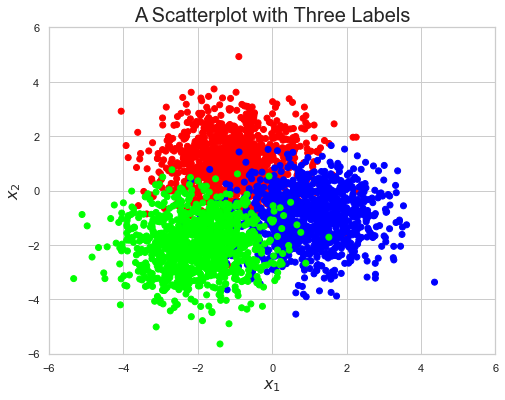

In [3]:
plt.figure(figsize = (8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap = ListedColormap(['#FF0000', '#0000FF', '#00FF00']))
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'A Scatterplot with Three Labels', fontsize = 20)

#### Notes
1. This scatterplot should be quite familiar by now.  


2. We have two features, $(x_1, x_2)$, and some label, which could be anything.
    * A row in our dataframe (or Excel spreadsheet) could be [house price, age, size].



3. Now imagine that the dots are three flavors, {red, blue, green}.
    * That is, a row in the dataframe contains three columns, a label and two features.
    * [flavor, $x_1$, $x_2$].  
    * For example, [red, -2, 2].

* We have **categorical labels** in our data, together with features (also called **predictors** or **explanatory variables**).



* We will build up the concept of a two-class categorical label based on material we have already discussed.  
    * We will motivate the idea through the use of a **latent** label (or variable).
    * Like time series, we do not observe the underlying DGP.
    * Rather we observe whether or not something **occurred** based on the **realization of a latent index**.  
    * The observation iss $\{0, 1\}$ or $\{$not observed, observed$\}$.



* This area of machine learning is called **classification**.
    * We seek to train a predictor function, $pred$, for a label using $K$ features, $x$.
    * $y_i = pred(x_{i1}, ..., x_{iK})$.



* The **realization** of this predictor, given a feature set, is sometimes called **"yhat"** or $\hat{y}$.



* It is easy to visualize conceptually the nature of this class of questions with scatterplots. 

### The Trade-Off: The Mean Squared Error and Bias/Variance Decomposition
* For any predictor, $\hat{y}$, of label, $y$, with a dataframe of size $N$, the MSE ${\displaystyle =\frac{1}{N}\sum_{i=1}^N(y_i - \hat{y_i})^2}$.



* In words, the MSE is the average of the **squared deviations** between our prediction and the truth.



* In practice, we do not much care about the overall MSE, but the MSE associated with the test set, in which case we simply limit the calculation to the test set.  



* It can be shown with some basic algebra that the MSE can be **decomposed**.  Namely,
    * MSE $\propto Var(\hat y) + Bias(\hat y)$



* What do the **variance** and **bias** of a learning algorithm measure? 



* **Variance** refers to the amount by which $\hat y$ would change if we train the algorithm using a different training set.  Since the training data are used to train the algorithm, a different training set would result in a different $\hat y$.  Ideally $\hat y$ should not considerably vary between training sets because an algorithm that has high variance implies that small changes in training sets can result in large changes in $\hat{y}$.  
    * Generally, more flexible statistical methods have higher variance.  That is, they are sensitive to their training sets.  See Zillow.



* **Bias** refers to the error that is introduced by approximating a real-life problem, which may be extremely complicated, by a simple representation.  
    * For example, linear regression assumes that there is a linear relationship between between the label and the features, $\hat y = x'\hat \beta$.  It is unlikely that any real-life use case truly has such a simple linear relationship, and so performing linear regression will undoubtedly result in some bias in the estimate of $\hat{y}$.  



* In general, more flexible statistical methods result in less bias.**  That is, including higher order terms (squares, cubics, or interactions) increases the predictive power (lower bias), but decreases our ability easily to interpret the results.



* This is called the **bias-variance tradeoff**.



**It is inherent in any machine learning algorithm**.  

### The Challenge

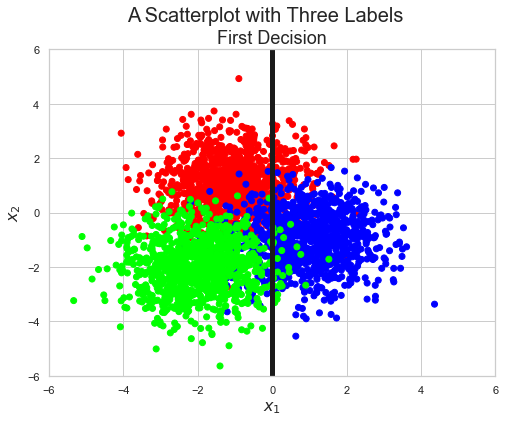

In [4]:
plt.figure(figsize = (8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap = ListedColormap(['#FF0000', '#0000FF', '#00FF00']))
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.suptitle(r'A Scatterplot with Three Labels', fontsize = 20)
plt.title(r'First Decision', fontsize = 18)
plt.axvline(x=0, linewidth=5, color='k')

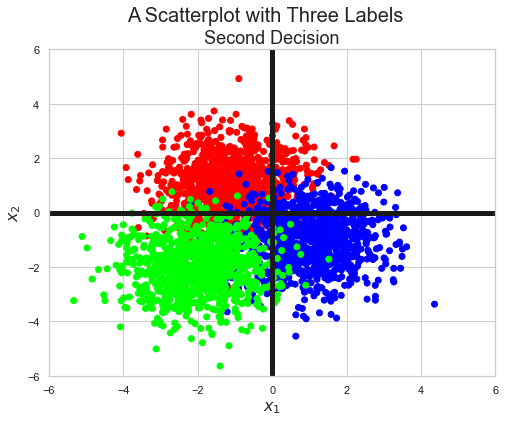

In [5]:
plt.figure(figsize = (8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap = ListedColormap(['#FF0000', '#0000FF', '#00FF00']))
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.suptitle(r'A Scatterplot with Three Labels', fontsize = 20)
plt.title(r'Second Decision', fontsize = 18)
plt.axvline(x=0, linewidth=5, color='k')
plt.axhline(y=0, linewidth=5, color='k')

### Yummy Use Case

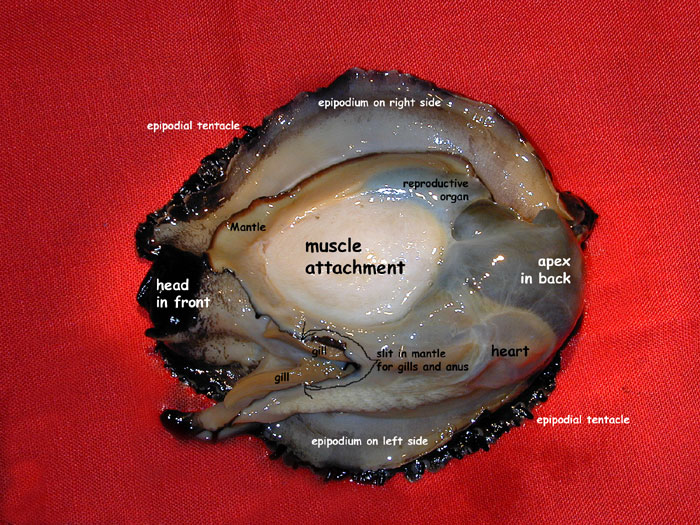

In [6]:
from IPython.display import Image
url = "http://www.marinebio.net/marinescience/06future/abimg/aa3770.jpg"
Image(url, width=500, height=500)

In [7]:
target_url = ("http://archive.ics.uci.edu/ml/machine-"
              "learning-databases/abalone/abalone.data")

# Read abalone data from UCI repository.
abalone = pd.read_csv(target_url, header=None, prefix="v")
abalone.columns = ['Gender', 'Length', 'Diameter', 'Height', 'Whole Weight',
                   'Shucked Weight', 'Viscera Weight', 'Shell Weight',
                   'Rings']

# Gender is a alpha character rather than a numeric label.  Create a numeric label {1, 2, 3} for Gender
# to pass to various machine learning predictors.
abalone['Ind'] = np.zeros((len(abalone),), dtype=np.int) + 1
for i in range(len(abalone)):
    if abalone['Gender'][i]=='I': abalone['Ind'][i] += 1
    if abalone['Gender'][i]=='M': abalone['Ind'][i] += 2

# Note the use of pandas get_dummies, which cleaves off the [0, 1] from the logical expression.
np.random.seed(12345)
abalone['index'] = np.random.uniform(low = 0, high = 1, size = len(abalone))
abalone['test'] = pd.get_dummies(abalone['index'] <= 0.3333)[1]

# We don't need the index, so drop it.
del abalone['index']

# Now we can create new train and test dataframes.
# Note the format of these command lines.
# It basically resolves as create spamtest as a subset of spam when test is 1.
# Otherwise, it is train.
abalonetest = abalone[abalone['test'] == 1]
abalonetrain = abalone[abalone['test'] == 0]

# Confirm data has been split properly.
print(len(abalonetrain))
print(len(abalonetest))
print(len(abalone))

2791
1386
4177


In [8]:
ytrain = abalonetrain['Ind'].to_numpy()
ytest = abalonetest['Ind'].to_numpy()

Xtrain = abalonetrain[['Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight', 
             'Viscera Weight', 'Shell Weight', 'Rings']].to_numpy()
Xtest = abalonetest[['Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight', 
             'Viscera Weight', 'Shell Weight', 'Rings']].to_numpy()

### Look Around the Training Set: Nearest Neighbors

* K Nearest Neighbors (KNN) is a popular classification tool.


* It is an antecedent to the Random Forest (RF) classifier.


* The name reflects exactly how the tool works (unlike many techniques in statistical learning).  
    * Start with training data: [label, $x_1$, $x_2$].  
    * For illustration purposes, set $K = 3$.  
    * A candidate test data point with feature values $(x_{1j}, x_{2j})$ arrives **without a label**.  
    
    
    
* The KNN predicator will determine the nearest $K$ points in the training set based on a Euclidian distance metric.  
    * Given the **known labels** in the training set, the predictor will assign a label based on a majority vote.
    * Two green and one red labels $\rightarrow$ a **green label**. 
    * If $K$ is even, ties are determined by flipping a coin.



* The Euclidian distance between to two points, $(x_{1j}$, $x_{2j})$ and $(x_{1k}$, $x_{2k})$, is $\sqrt{(x_{1j} - x_{2j})^2 + (x_{1k} - x_{2k})^2}$



* This is done for every point in the test set, in which case we can generate the usual confusion matrix, as well as measures of accuracy and mean-squared error. 

In [9]:
NN = 3
how = 'distance'

knn = neighbors.KNeighborsClassifier(NN, how)
knn.fit(Xtrain, ytrain)

ypred = knn.predict(Xtest)
cm = confusion_matrix(ytest, ypred)
KNNcm = cm
MSE = mean_squared_error(ytest, ypred)

ACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))

table = [[" ","1", "2", "3"],
         ["1", cm[0][0], cm[0][1], cm[0][2]], 
         ["2", cm[1][0], cm[1][1], cm[1][2]], 
         ["3", cm[2][0], cm[2][1], cm[2][2]]]

print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

The confusion matrix is:
╒═══╤═════╤═════╤═════╕
│   │  1  │  2  │  3  │
├───┼─────┼─────┼─────┤
│ 1 │ 171 │ 60  │ 207 │
├───┼─────┼─────┼─────┤
│ 2 │ 48  │ 332 │ 81  │
├───┼─────┼─────┼─────┤
│ 3 │ 172 │ 89  │ 226 │
╘═══╧═════╧═════╧═════╛
The Accuracy Rate is 0.525974025974026
The Mean Squared Error is 1.2943722943722944


### Guessing?

In [10]:
ypred = np.random.permutation(ytest)
cm = confusion_matrix(ytest, ypred)
RANcm = cm
MSE = mean_squared_error(ytest, ypred)

ACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))

table = [[" ","1", "2", "3"],
         ["1", cm[0][0], cm[0][1], cm[0][2]], 
         ["2", cm[1][0], cm[1][1], cm[1][2]], 
         ["3", cm[2][0], cm[2][1], cm[2][2]]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

The confusion matrix is:
╒═══╤═════╤═════╤═════╕
│   │  1  │  2  │  3  │
├───┼─────┼─────┼─────┤
│ 1 │ 146 │ 133 │ 159 │
├───┼─────┼─────┼─────┤
│ 2 │ 148 │ 159 │ 154 │
├───┼─────┼─────┼─────┤
│ 3 │ 144 │ 169 │ 174 │
╘═══╧═════╧═════╧═════╛
The Accuracy Rate is 0.34559884559884557
The Mean Squared Error is 1.3102453102453102


#### Notes
* The simplest predictor is a random guess.  We have three classes, so we guess at random.
* For example, with two classes, such as spam, we could flip a coin.  
* An such a predictor is, not suprisingly, accurate about one-third of the time.  That is, an accuracy rate of about 33.3%.  
* A simple algorithm such as KNN increases this accuracy to 54%.
* This is why we use such algorithms for prediction: to improve accuracy over merely guessing.

### Random Forest (RF) Classifier

* The Random Forest Classifier is closely related to KNN because both classifiers identify a "weighted neighborhood" in the feature space, identify the known labels in that neighborhood (training set), and assign labels to unlabeled data (test set) based on a clear decision rule.  



* For KNN, it's majority rules with each point having the same weight.  For example, when $K=3$, KNN identifies the labels for the three closest points in the feature space.  If two are blue and one is red, the candidate receives a blue label.



* In this context, the RF classifier has a more complicated method to build the weights based on decision trees.  It is an easy classifier to implement and has become very popular, in particular in classification of massive datasets because it is easy to parallelize the process. 



* In a typical setting, 100 trees works.



* A decision tree is similar to calling your bank and getting the automated teller, which asks:
    * whether you're calling about a commercial or residential account;
    * and then asks whether you're calling about a checking or savings account.



* A decision tree works in the identical manner by partitioning the feature space.

In [11]:
from sklearn.ensemble import RandomForestClassifier

np.random.seed(12345)
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(Xtrain, ytrain)
ypred = rf.predict(Xtest)
cm = confusion_matrix(ytest, ypred)
RFcm = cm
MSE = mean_squared_error(ytest, ypred)

ACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))

table = [[" ","1", "2", "3"],
         ["1", cm[0][0], cm[0][1], cm[0][2]], 
         ["2", cm[1][0], cm[1][1], cm[1][2]], 
         ["3", cm[2][0], cm[2][1], cm[2][2]]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

The confusion matrix is:
╒═══╤═════╤═════╤═════╕
│   │  1  │  2  │  3  │
├───┼─────┼─────┼─────┤
│ 1 │ 185 │ 52  │ 201 │
├───┼─────┼─────┼─────┤
│ 2 │ 41  │ 367 │ 53  │
├───┼─────┼─────┼─────┤
│ 3 │ 176 │ 90  │ 221 │
╘═══╧═════╧═════╧═════╛
The Accuracy Rate is 0.5577200577200577
The Mean Squared Error is 1.2582972582972582


### Comparing KNN and RF

In [12]:
# Comparing KNN, RF, and random designation.
# Remember that the on-diagonals are correctly classified.

print("1 is Female, 2 is Infant, and 3 is Male")
print("")
print("KNN Confusion Matrix")
print(KNNcm)
print()
print("RF Confusion Matrix")
print(RFcm)
print()
print("Random Confusion Matrix")
print(RANcm)

1 is Female, 2 is Infant, and 3 is Male

KNN Confusion Matrix
[[171  60 207]
 [ 48 332  81]
 [172  89 226]]

RF Confusion Matrix
[[185  52 201]
 [ 41 367  53]
 [176  90 221]]

Random Confusion Matrix
[[146 133 159]
 [148 159 154]
 [144 169 174]]


* We have improved classifying Females, but do slightly worse at classifying Infants and Males.  



* It must be recognized, however, that both approaches are vastly superior to an algorithm of random assignment.  (Remember, we humans always have the ability to guess at random.  We program algorithms to improve on this process.)

### The Linear Discriminant Analysis (LDA) Classifier

* We saw that the logit classifier is used for the two-class label: $\{$yes, no$\}$, $\{$on, off$\}$, or $\{$1, 0$\}$.  We  developed predictors based on test data by generating predicted probabilities for the training set and applying discriminant thresholds.  



* Consider a less direct method to estimating these probabilities. 



* In this alternative approach, we model the distribution of the features, $x_i$, separately in each of the label categories (technically, "given $y_i$").  
    * We apply Bayes theorem of inverse probability to determine the probability an unlabel candidate is in category $j$ $conditional$ on the the data: Pr($y_i$ is in category $j$ | $x_i$).  
    * Technically, when these distributions are assumed to be normal and independent, it turns out that the model is very similar in form to logistic regression.

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

lda.fit(Xtrain, ytrain)
ypred = lda.predict(Xtest)
MSE = mean_squared_error(ytest, ypred)

cm = confusion_matrix(ytest, ypred)

ACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))

table = [[" ","1", "2", "3"],
         ["1", cm[0][0], cm[0][1], cm[0][2]], 
         ["2", cm[1][0], cm[1][1], cm[1][2]], 
         ["3", cm[2][0], cm[2][1], cm[2][2]]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

The confusion matrix is:
╒═══╤═════╤═════╤═════╕
│   │  1  │  2  │  3  │
├───┼─────┼─────┼─────┤
│ 1 │ 129 │ 66  │ 243 │
├───┼─────┼─────┼─────┤
│ 2 │ 23  │ 360 │ 78  │
├───┼─────┼─────┼─────┤
│ 3 │ 116 │ 106 │ 265 │
╘═══╧═════╧═════╧═════╛
The Accuracy Rate is 0.5440115440115441
The Mean Squared Error is 1.233044733044733


### The Multinomial Logit (MNL) Classifier

* The multinominal logit (MNL) classifier is an extension of the logit classifier and is similar to the LDA classifier.  
    * The MNL extends the logit model from a label with two categories to a label with multiple categories.  
    * Here we estimate the multinomial logit using the training set and generate predicted probabilities for the test data.  
    * The classification is simply the category with the highest predicted probability.  Oddly, this model is not used much outside of economics.  

In [14]:
from statsmodels.discrete.discrete_model import MNLogit

endogtrain = abalonetrain['Ind']
exogtrain = abalonetrain[['Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight', 
             'Viscera Weight', 'Shell Weight', 'Rings']]
exogtest = abalonetest[['Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight', 
             'Viscera Weight', 'Shell Weight', 'Rings']]

mnlogit = MNLogit(endogtrain, exogtrain).fit()
print(mnlogit.summary())
print()
pred = np.array(mnlogit.predict(exogtest))

prediction = np.zeros((len(ypred),), dtype=np.int) + 3
for i in range(len(prediction)): 
    if pred[i][0] > pred[i][1] and pred[i][0] > pred[i][2]: prediction[i] = 1
    if pred[i][1] > pred[i][0] and pred[i][1] > pred[i][2]: prediction[i] = 2
        
cm = confusion_matrix(ytest, prediction)
MSE = mean_squared_error(ytest, prediction)

ACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))

table = [[" ","1", "2", "3"],
         ["1", cm[0][0], cm[0][1], cm[0][2]], 
         ["2", cm[1][0], cm[1][1], cm[1][2]], 
         ["3", cm[2][0], cm[2][1], cm[2][2]]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

Optimization terminated successfully.
         Current function value: 0.859928
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:                    Ind   No. Observations:                 2791
Model:                        MNLogit   Df Residuals:                     2775
Method:                           MLE   Df Model:                           14
Date:                Thu, 02 Dec 2021   Pseudo R-squ.:                  0.2148
Time:                        06:23:00   Log-Likelihood:                -2400.1
converged:                       True   LL-Null:                       -3056.5
Covariance Type:            nonrobust   LLR p-value:                9.219e-272
         Ind=2       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Length            25.6111      3.246      7.889      0.000      19.248      31.974
Diameter         

### The Naive Bayes (NB) Classifier

The Naive Bayes Classifier uses Bayes' Theorem together with the naive assumption that, conditional on the label category, the value of a particular feature is independent of the value of any other feature.  In this situation, for example, Length is independent of Diameter, conditional on being Female.  Given this simplification, it simple to apply Bayes' Theorem to calculate posterior probabilties to predict a label (conditional on features).  While LDA assumes normal probability conditional on the label category (together with equal covariances), NB assumes features are independent conditional on the label category.

The NB classifier has worked well in real-world situations, including spam filtering. 

In [15]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(Xtrain, ytrain)
ypred = gnb.predict(Xtest)
MSE = mean_squared_error(ytest, ypred)

cm = confusion_matrix(ytest, ypred)

ACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))

table = [[" ","1", "2", "3"],
         ["1", cm[0][0], cm[0][1], cm[0][2]], 
         ["2", cm[1][0], cm[1][1], cm[1][2]], 
         ["3", cm[2][0], cm[2][1], cm[2][2]]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

The confusion matrix is:
╒═══╤═════╤═════╤════╕
│   │  1  │  2  │ 3  │
├───┼─────┼─────┼────┤
│ 1 │ 265 │ 91  │ 82 │
├───┼─────┼─────┼────┤
│ 2 │ 34  │ 384 │ 43 │
├───┼─────┼─────┼────┤
│ 3 │ 273 │ 131 │ 83 │
╘═══╧═════╧═════╧════╛
The Accuracy Rate is 0.5281385281385281
The Mean Squared Error is 1.2402597402597402


### Our Classifiers and Their Performance

In [16]:
# KNN, RF, LDA, MNL, and NB Classifiers using Abalone data.  Let's bring this all together for ease of use.

NN = 65
how = 'distance'
ypred = knn.predict(Xtest)
cm = confusion_matrix(ytest, ypred)
knnACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))
knnMSE = mean_squared_error(ytest, ypred)

rf = RandomForestClassifier(n_estimators = 20)
rf.fit(Xtrain, ytrain)
ypred = rf.predict(Xtest)
cm = confusion_matrix(ytest, ypred)
rfACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))
rfMSE = mean_squared_error(ytest, ypred)

lda = LinearDiscriminantAnalysis()
lda.fit(Xtrain, ytrain)
ypred = lda.predict(Xtest)
cm = confusion_matrix(ytest, ypred)
ldaACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))
ldaMSE = mean_squared_error(ytest, ypred)

mnlogit = MNLogit(endogtrain, exogtrain).fit()
pred = np.array(mnlogit.predict(exogtest))
prediction = np.zeros((len(ypred),), dtype=np.int) + 3
for i in range(len(prediction)): 
    if pred[i][0] > pred[i][1] and pred[i][0] > pred[i][2]: prediction[i] = 1
    if pred[i][1] > pred[i][0] and pred[i][1] > pred[i][2]: prediction[i] = 2
cm = confusion_matrix(ytest, prediction)
mnlACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))
mnlMSE = mean_squared_error(ytest, prediction)

gnb = GaussianNB()
gnb.fit(Xtrain, ytrain)
ypred = gnb.predict(Xtest)
cm = confusion_matrix(ytest, ypred)
nbACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))
nbMSE = mean_squared_error(ytest, ypred)

# What would a confusion matrix with random allocation look like?

ypred = np.random.permutation(ytest)
cm = confusion_matrix(ytest, ypred)
ranACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))
ranMSE = mean_squared_error(ytest, ypred)

Optimization terminated successfully.
         Current function value: 0.859928
         Iterations 8


In [17]:
# Here is the relative performance of our classifiers, including random guessing.

print('Accuracy of KNN, RF, LDA, MNL, NB, and Guessing')
print('%f %f %f %f %f %f' % (knnACC, rfACC, ldaACC, mnlACC, nbACC, ranACC))
print('')
print('MSE of KNN, RF, LDA, MNL, NB, and Guessing')
print('%f %f %f %f %f %f' % (knnMSE, rfMSE, ldaMSE, mnlMSE, nbMSE, ranMSE))

Accuracy of KNN, RF, LDA, MNL, NB, and Guessing
0.525974 0.525253 0.544012 0.562049 0.528139 0.320346

MSE of KNN, RF, LDA, MNL, NB, and Guessing
1.294372 1.336219 1.233045 1.182540 1.240260 1.359307


#### Notes
* The obvious question is, "Which one to use?"  
* KNN, RF, LDA, and NB scale very nicely with massive data because the algorithms can be easily parallelized.  
* For NB, this is because the naive assumption of independence allows the probabilities to be estimated independently.  * In my experience, MNL does not scale as well with massive data.
* Again, the decision is **yours as a data scientist**, and not the machines.

### Lab

In [18]:
!jupyter nbconvert --to script "CRA Class 4.ipynb"

[NbConvertApp] Converting notebook CRA Class 4.ipynb to script
[NbConvertApp] Writing 21980 bytes to CRA Class 4.py
